<a href="https://colab.research.google.com/github/srfinley/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2019-09-17 19:39:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.04s   

2019-09-17 19:39:40 (461 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [3]:
# Load Data
df = pd.read_csv('house-votes-84.data', 
                 header=None,
                 names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'])
print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [5]:
#y/n to numbers, ? to NaN
df = df.replace({'?':np.NaN, 'n':0, 'y':1})

df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [6]:
#filter a dem df and a rep df
dem = df[df['party'] == 'democrat']
rep = df[df['party'] == 'republican']

rep.shape,dem.shape

((168, 17), (267, 17))

In [12]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  #stderr = np.std(data, ddof=1) / np.sqrt(n)
  margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  print(margin_of_error)
  return (mean, mean - margin_of_error, mean + margin_of_error)

confidence_interval(rep['south-africa'].dropna())

0.07788820497097171


(0.6575342465753424, 0.5796460416043707, 0.7354224515463141)

With a margin of error of $\pm$7.8% and 95% confidence, Republicans support the South Africa bill at a rate of 65.8%.

---

We can conclude with 95% confidence based on our sample that Republicans support the South Africa bill at a rate between 58.0% and 73.5%.

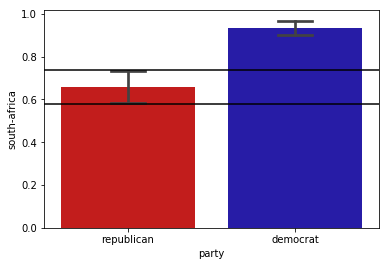

In [17]:
#a plot of the south africa vote
politics = sns.color_palette(["#DE0100","#1405BD"])
sns.set_palette(politics)

ax = sns.barplot(x="party",y="south-africa",data=df,
                 capsize=.2)

#confirm the locations of the error bar seaborn automatically inserts
ax.axhline(.58,color='black')
ax.axhline(.735,color='black')

0.07788820497097171
0.07788820497097171
0.07788820497097171


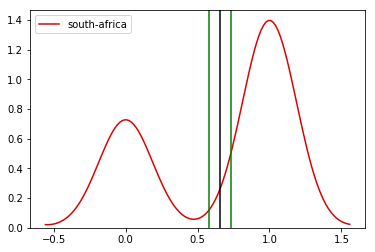

In [20]:
ax = sns.kdeplot(rep['south-africa'].dropna())
ax.axvline(x=confidence_interval(rep['south-africa'].dropna())[1], color='green')
ax.axvline(x=confidence_interval(rep['south-africa'].dropna())[2], color='green')
ax.axvline(x=confidence_interval(rep['south-africa'].dropna())[0], color='k');

In [25]:
#chi square data

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [26]:
df.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [27]:
df['sex'].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [28]:
df['race'].value_counts()

 White                 27816
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: race, dtype: int64

In [29]:
df = df.sort_values(by='race', ascending=True)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
17733,38,Private,33105,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Amer-Indian-Eskimo,Male,0,0,70,United-States,>50K
20517,46,Private,26781,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,0,0,40,United-States,<=50K
25016,30,Private,299223,Some-college,10,Divorced,Sales,Unmarried,Amer-Indian-Eskimo,Female,0,0,40,United-States,<=50K
22244,34,Private,79637,Bachelors,13,Never-married,Exec-managerial,Own-child,Amer-Indian-Eskimo,Female,0,0,40,United-States,<=50K
19089,58,Federal-gov,30111,Some-college,10,Widowed,Prof-specialty,Unmarried,Amer-Indian-Eskimo,Female,0,0,40,United-States,<=50K


In [32]:
contingency_table = pd.crosstab(df['sex'],df['race'],margins=True)

contingency_table

race,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,All
sex,,,,,,
Female,119,346,1555,109,8642,10771
Male,192,693,1569,162,19174,21790
All,311,1039,3124,271,27816,32561


In [34]:
fcount = contingency_table.iloc[0][0:5].values
fcount

array([ 119,  346, 1555,  109, 8642])

In [35]:
mcount = contingency_table.iloc[1][0:5].values
mcount

array([  192,   693,  1569,   162, 19174])

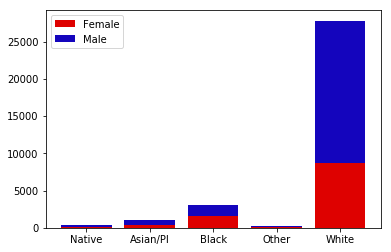

In [46]:
races = ["Native","Asian/PI","Black","Other","White"]

plot = plt.bar(races,fcount)
plot2 = plt.bar(races,mcount,bottom=fcount)
plt.legend((plot,plot2), ('Female','Male'))
plt.show();

In [52]:
#isolate the sums for each row (sex) and column (race)
row_sums = contingency_table.iloc[0:2, 5].values
col_sums = contingency_table.iloc[2,0:5].values

row_sums,col_sums

(array([10771, 21790]), array([  311,  1039,  3124,   271, 27816]))

In [53]:
total = contingency_table.loc['All','All']
total

32561

In [54]:
#constructing the expected numpy array
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)
  

expected = np.array(expected)
print(expected.shape)  
print(expected)

(2, 5)
[[  102.87709223   343.69549461  1033.40204539    89.64531188
   9201.3800559 ]
 [  208.12290777   695.30450539  2090.59795461   181.35468812
  18614.6199441 ]]


In [55]:
#viewing the observed crosstab
observed = pd.crosstab(df['sex'], df['race']).values
print(observed.shape)
observed

(2, 5)


array([[  119,   346,  1555,   109,  8642],
       [  192,   693,  1569,   162, 19174]])

In [56]:
#mathing the arrays directly, without any loops
chi_squared = ((observed - expected)**2/(expected)).sum() 
print(f"Chi-Squared: {chi_squared}")

Chi-Squared: 454.2671089131088


In [57]:
#Just Using Scipy, Thank God
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 454.2671089131088
P-value: 5.192061302760456e-97
Degrees of Freedom: 4
Expected: 
 [[  102.87709223   343.69549461  1033.40204539    89.64531188
   9201.3800559 ]
 [  208.12290777   695.30450539  2090.59795461   181.35468812
  18614.6199441 ]]


With a p value of 5.19x10^-97, we reject the null hypothesis that race and sex are unrelated. Hmmmmm.

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)